In [ ]:
import polars as pl
import numpy as np
from scipy.stats import false_discovery_control
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
# import os

## Helper Functions

In [2]:
def natural_sort_variants(df: pl.DataFrame, chr_col: str = "chrom", pos_col: str = "pos") -> pl.DataFrame:
	return (
		df.with_columns(
			# Create a temporary column 'chr_rank' for sorting
			pl.col(chr_col)
			.str.replace("chr", "") # Remove 'chr' prefix
			.str.replace("X", "23") # Handle Sex chromosomes
			.str.replace("Y", "24")
			.str.replace("M", "25") # Handle Mitochondria if present
			.str.replace("MT", "26")
			.cast(pl.Int32, strict=False) # Convert to Integer (strict=False turns unknown contigs to null)
			.fill_null(999) # Put weird contigs at the end
			.alias("chr_rank")
		)
		.sort(["chr_rank", pos_col]) # Sort by Rank, then Position
		.drop("chr_rank") # Remove the temp column
	)

In [3]:
def adaptive_fdr_cut(df: pl.DataFrame, fp_cut: float) -> pl.DataFrame:
	"""
	Takes a DataFrame containing a 'q' column, calculates the adaptive cutoff metric,
	and adds a boolean 'pred' column using Polars' built-in rank method. Applies a 
	cutoff where the expected number of false positives in the selected set is less 
	than a specific number defined by fp_cut
	"""
	return df.with_columns(
		((pl.col("q").rank(method="ordinal") * pl.col("q")) < fp_cut).alias("pred")
	)

In [4]:
def adaptive_fdr_pred(df: pl.DataFrame, score_col: str, fp_cut: float = 0.5) -> pl.DataFrame:
	"""
	Applies FDR Benjamini-Hochberg correction on the specified score column and
	generates predictions from the the q-values using an adaptive false positive cutoff.
	"""
	
	# Split Complete Cases (C>T) and Nulls
	df_ct = df.filter(pl.col(score_col).is_not_null())
	df_nct = df.filter(pl.col(score_col).is_null())
	
	# Handle Non-C>T mutations (Null scores)
	# Non-C>T mutations are assumed to be real mutations in this context, hence we set pred = True
	df_nct = df_nct.with_columns([
		pl.lit(None, dtype=pl.Float64).alias(score_col),
		pl.lit(None, dtype=pl.Float64).alias("q"),
		pl.lit(True).alias("pred")
	])
		

	if df_ct.height == 0:
		return df_nct

	# Handle C>T mutations (Scores exist)
	## Define machine epsilon for float type (smallest positive float with which 1.0 + eps != 1.0)
	machine_eps = np.finfo(float).eps
	
	df_ct = (
		df_ct
		## Substitute zeros with machine epsilon 
		.with_columns(
			pl.when(pl.col(score_col) == 0)
			.then(machine_eps)
			.otherwise(pl.col(score_col))
			.alias(score_col)
		)
		## Calculate q-values using BH correction from SciPy
		.with_columns(
			pl.col(score_col).map_batches(
				lambda x: false_discovery_control(x, method='bh'), 
				return_dtype=pl.Float64
			).alias("q")
		)
		## Apply adaptive FDR cut
		.pipe(lambda df: adaptive_fdr_cut(df, fp_cut))		
	)
	
	# Combine and sort
	final_df = pl.concat([df_ct, df_nct], how="vertical").pipe(natural_sort_variants)
	
	return final_df


In [5]:
def predict(df, score_col, threshold):
    return df.with_columns(
        ## Lower scores from MOBSNVF represents real muatations
        (pl.col(score_col) <= threshold).alias("pred")
    )

In [6]:
def get_eval_metrics(truth: pl.Series, pred: pl.Series) -> dict:

    cm = confusion_matrix(truth, pred)
    TN, FP, FN, TP = cm.ravel()

    eval_metrics = {
        "precision": TP / (TP + FP),
        "recall": TP / (TP + FN),
        "specificity": TN / (TN + FP),
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "confusion_matrix": cm
    }

    return eval_metrics

In [ ]:
def plot_eval_metrics(
        df, 
        x_col: str = "fp_cut", 
        y_col: str = "perf_value", 
        hue_col: str = "perf_metric", 
        font_scale: float = 1.5, 
        linewidth: int = 3, 
        width: int = 7, 
        height: int = 5, 
        context: str = "paper"
    ) -> None:

    with sns.plotting_context(context, font_scale=font_scale):

        plt.figure(figsize=(width, height)) 

        ax = sns.lineplot(df, x=x_col, y=y_col, hue=hue_col, linewidth=linewidth)
        ax.set_xscale("log")

        sns.move_legend(
            ax, 
            "lower center", 
            bbox_to_anchor=(0.5, 1), 
            ncol=perf["perf_metric"].n_unique(), 
            title=None, 
            frameon=False, 
            fontsize='small'
        )

## Analysis

### Compile sample scores, perform adaptive FDR prediction, and evaluate performance

In [8]:
paths = glob.glob("../evaluations/EGAD00001004066/somatic_vcf-dp10_msec-1234-excluded/model-scores_truths/*/*_mobsnvf-scores_truths.tsv")

In [9]:
thresholds = np.geomspace(1e-16, 1.0, num=100)
threshold_metrics = []

for path in tqdm(paths):
    df = pl.read_csv(path, separator="\t")
    df = df.drop("score", "snv")

    sample_name = {"sample" : path.split("/")[-2]}

    for thresh in thresholds:
        df_pred = adaptive_fdr_pred(df, score_col="FOBP", fp_cut=thresh)
        eval_metrics = get_eval_metrics(df_pred["truth"], df_pred["pred"])
        eval_metrics = sample_name | {"fp_cut": thresh} | eval_metrics

        threshold_metrics.append(eval_metrics)

threshold_metrics = pl.DataFrame(threshold_metrics)

  0%|          | 0/13 [00:00<?, ?it/s]/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
  8%|▊         | 1/13 [00:01<00:15,  1.30s/it]/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykernel_3831039/499570090.py:7: RuntimeWarning: invalid value encountered in scalar divide
  "precision": TP / (TP + FP),
/tmp/ipykerne

### Cutoff Threshold vs Perf Metric Plots

In [10]:
perf = threshold_metrics.unpivot(index=["sample", "fp_cut"], on=["precision", "recall", "specificity"], variable_name="perf_metric", value_name="perf_value")

In [11]:
perf_liver = perf.filter(pl.col("sample").str.contains("Liver"))
perf_colon = perf.filter(pl.col("sample").str.contains("Colon"))

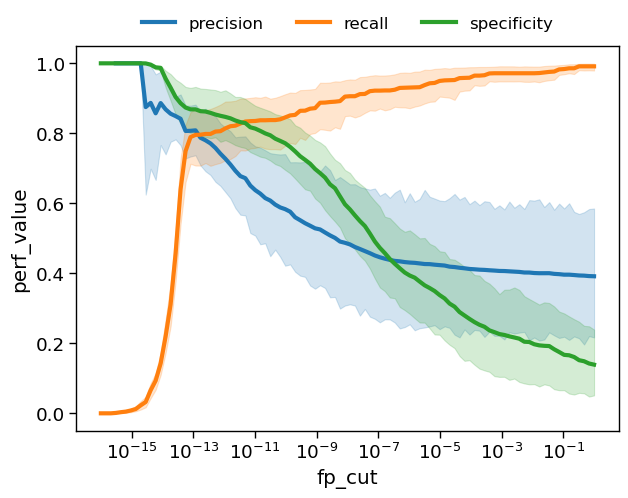

In [12]:
plot_eval_metrics(perf)

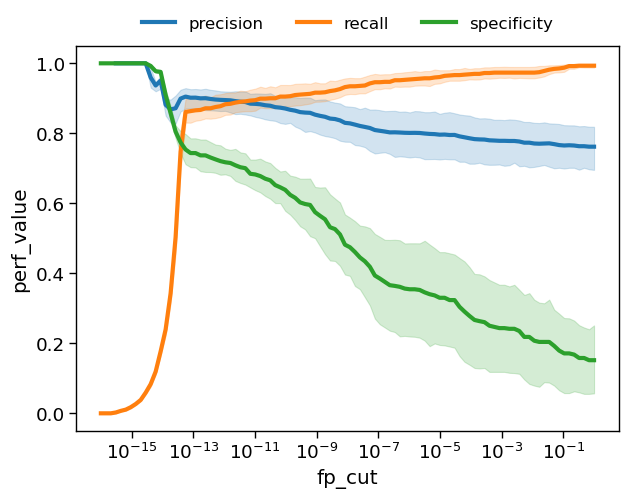

In [13]:
plot_eval_metrics(perf_colon)

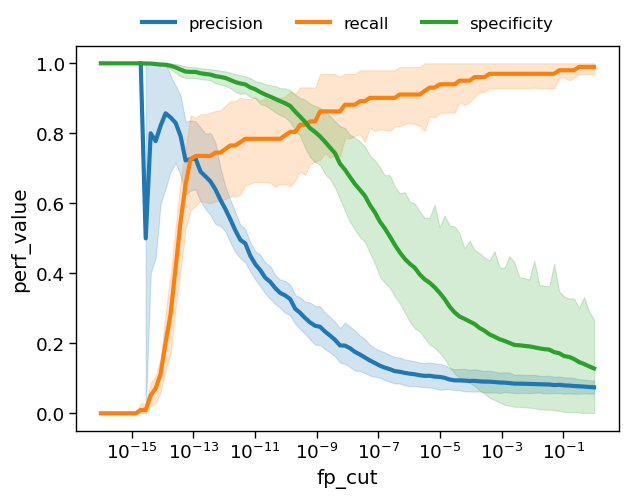

In [14]:
plot_eval_metrics(perf_liver)

### Confusion Matrices

Precision: 0.9225, Recall: 0.8815, Specificity: 0.6970


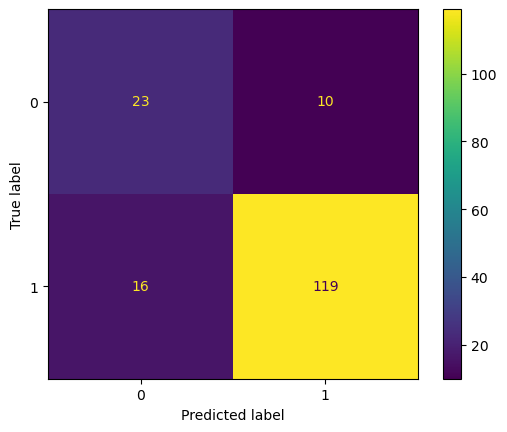

In [15]:
path = paths[0]
df = pl.read_csv(path, separator="\t")
df_pred = adaptive_fdr_pred(df, score_col="FOBP", fp_cut=1e-12)
# df_pred = predict(df, score_col="FOBP", threshold=1e-11)

eval_metrics = get_eval_metrics(df_pred["truth"], df_pred["pred"])

ConfusionMatrixDisplay(eval_metrics["confusion_matrix"]).plot()
print(f"Precision: {eval_metrics['precision']:.4f}, Recall: {eval_metrics['recall']:.4f}, Specificity: {eval_metrics['specificity']:.4f}")